<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/master/notebooks/intro/strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classic Supervised Machine Learning Strategies

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']

cmap = ListedColormap(colors) 

In [2]:
import sklearn
sklearn.__version__

'0.22.1'

## Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [0]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/notebooks/classic/insurance-customers-1500.csv', sep=';')

In [4]:
df.head()

speed   age  miles  group
0   98.0  44.0   25.0      1
1  118.0  54.0   24.0      1
2  111.0  26.0   34.0      0
3   97.0  25.0   10.0      2
4  114.0  38.0   22.0      1

In [5]:
df.describe()

speed          age        miles        group
count  1500.000000  1500.000000  1500.000000  1500.000000
mean    122.492667    44.980667    30.434000     0.998667
std      17.604333    17.130400    15.250815     0.816768
min      68.000000    16.000000     1.000000     0.000000
25%     108.000000    32.000000    18.000000     0.000000
50%     120.000000    42.000000    29.000000     1.000000
75%     137.000000    55.000000    42.000000     2.000000
max     166.000000   100.000000    84.000000     2.000000

In [0]:
y = df['group'].values

In [0]:
X = df.drop('group', axis='columns').values

### We restrict ourselves to two dimensions for now

Because this is all we really can visualize in 2d

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html

from matplotlib.ticker import FuncFormatter

import numpy as np

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 110
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)

def plot_samples(samples, ax, legend):
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
    ax.add_artist(class_legend)
    
    return ax, scatter

def plot_samples_markers(samples, ax, legend):
  y = samples[2]
  bad = samples[y == 0]
  good = samples[y == 1]
  fair = samples[y == 2]

  labels = ["High Risk", "Low Risk", "Medium Risk"]
  classes = [bad, good, fair]
  markers = ['v', 'd', '^']

  for label, clazz, color, marker in zip(labels, classes, colors, markers):
      ax.scatter(
          clazz[0], 
          clazz[1],
          label=label,
          color=color,
          marker=marker,
          s=100,
          edgecolors='k',
          alpha=0.8)
  if legend:
    ax.legend()
  return ax, None
      

def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   n_samples=None, proba=True, prediction=True, legend=True, 
                   scatter=True,
                   ax=None
                  ):
    if x_data is not None:
      assert x_data.shape == y_data.shape, "x and y must have the same dimension"
    if x_data  is not None and ground_truth is not None:
      assert x_data.shape == ground_truth.shape, "input and ground truth need the same number of samples"
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots()

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    
    if scatter:
      samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
      if n_samples:
        samples = samples.sample(n_samples, random_state=42)
      plot_samples_markers(samples, ax, legend)
    return ax 


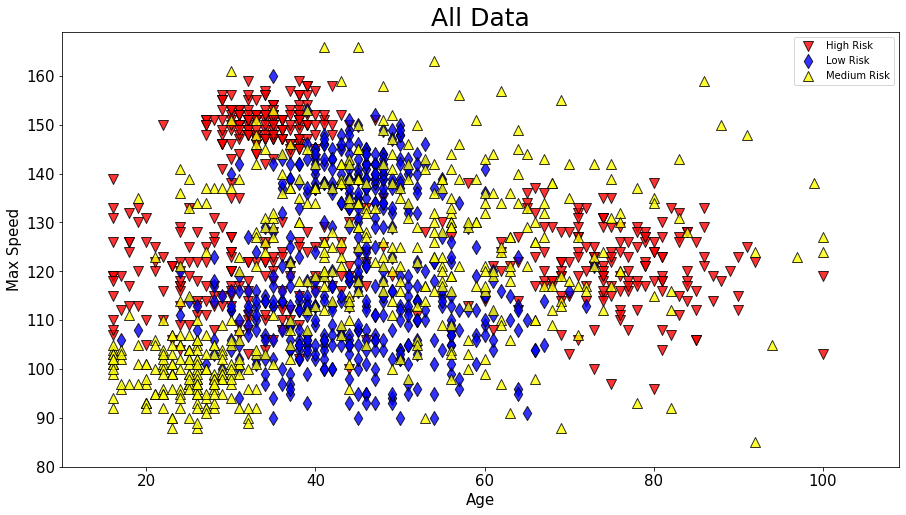

In [9]:
ax = plotPrediction(None, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data")

## Splitting into test and training data

<img src='https://github.com/djcordhose/ml-workshop/blob/master/img/insurance/generalization.jpg?raw=1'>

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 3), (300, 3), (1200,), (300,))

In [0]:
# train_test_split?

In [12]:
# we have (almost) the same number of samples per categoery 
# in the training...
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([401, 400, 399]))

In [13]:
# ... and test dataset
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([100, 100, 100]))

In [0]:
# just the first two dimensions
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

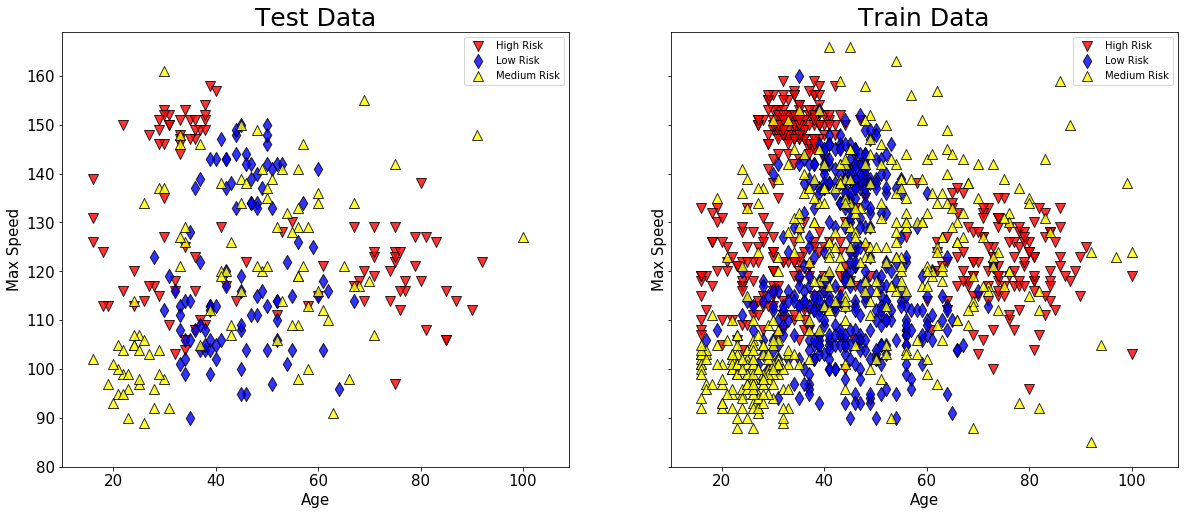

In [15]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,8))
la, ra = ax.flatten()
plotPrediction(None, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, title="Test Data", ax = la)

plotPrediction(None, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train, title="Train Data", ax=ra)

# Exercise: Experiment with train/test split

* Execute the notebook up to this point
* change the split ratio between train and test, maybe to 60/40
* change the random seed, why would you want to use it in the first place? is this even a good idea?
* what happens if you do not stratify?


## Overview of most important strategies

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

https://scikit-learn.org/stable/supervised_learning.html

<img src='https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/clf_comp.png?raw=1'>

* accuracy is plotted
* decision boundaries are plotted as background
* the darker the color the higher the probability

## Gaussian Naive Bayes: Simple, but effective in cases of blobs

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

* _Bayes_: Bayes’ theorem gives a mean to reverse conditional probabilities
* _Naive_: refers to our assumption that all features are independent to simplify the problem
* _Gaussian_: assumption: each category can be described using a Gaussian distribution

How it works
  * Maximum Likelihood Estimation: assuming we have a Gaussian distribution of independent variables which set of parameters has the highest probability of fitting our dataset (https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation)
  * practically is done by computing the mean and the standard deviation from our training data (https://machinelearningmastery.com/naive-bayes-for-machine-learning/, https://towardsdatascience.com/maximum-likelihood-estimation-explained-normal-distribution-6207b322e47f) per category


Features  
  * require a small amount of training data to estimate the necessary parameters
  * fast training
  * probability estimation often is poor
  * allows for online learning

https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [0]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

In [17]:
%%time

clf.fit(X_train_2_dim, y_train)

CPU times: user 2.26 ms, sys: 0 ns, total: 2.26 ms
Wall time: 2.55 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [18]:
# you can set set priors explicitly
# clf = GaussianNB(priors=[0.33, 0.33, 0.34])

# based on number of samples per category
clf.class_prior_

array([0.33416667, 0.33333333, 0.3325    ])

In [19]:
clf.class_count_

array([401., 400., 399.])

In [20]:
# mean per category
clf.theta_

array([[130.55860349,  46.27680798],
       [119.83      ,  44.865     ],
       [117.49874687,  43.26566416]])

In [21]:
clf.sigma_

array([[250.40616694, 449.40716818],
       [257.22610031,  77.24177531],
       [328.10964786, 344.32541284]])

In [22]:
input = [[100.0, 48.0], [150.0, 78.0], [100.0, 18.0]]
# should be [1, 0, 2] = [good, bad, mediocre]
clf.predict(input)

array([1, 0, 2])

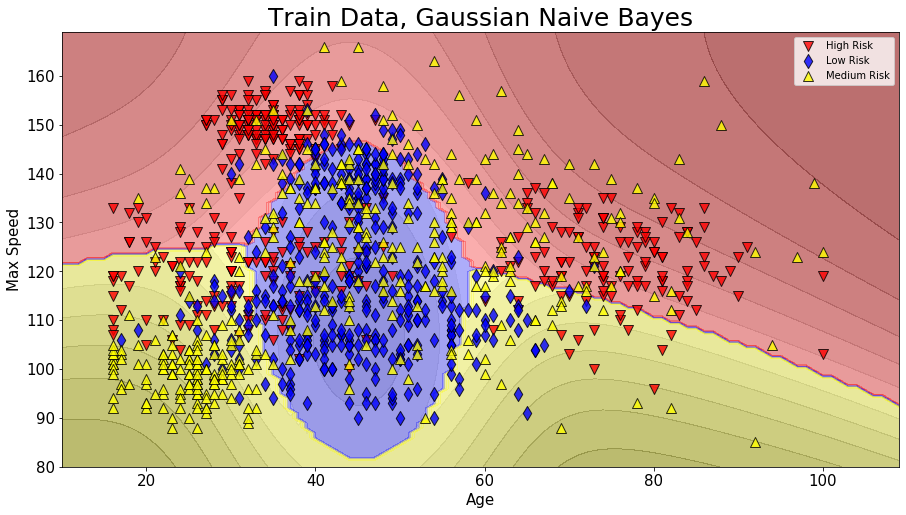

In [23]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Gaussian Naive Bayes")

In [24]:
clf.score(X_train_2_dim, y_train)

0.6083333333333333

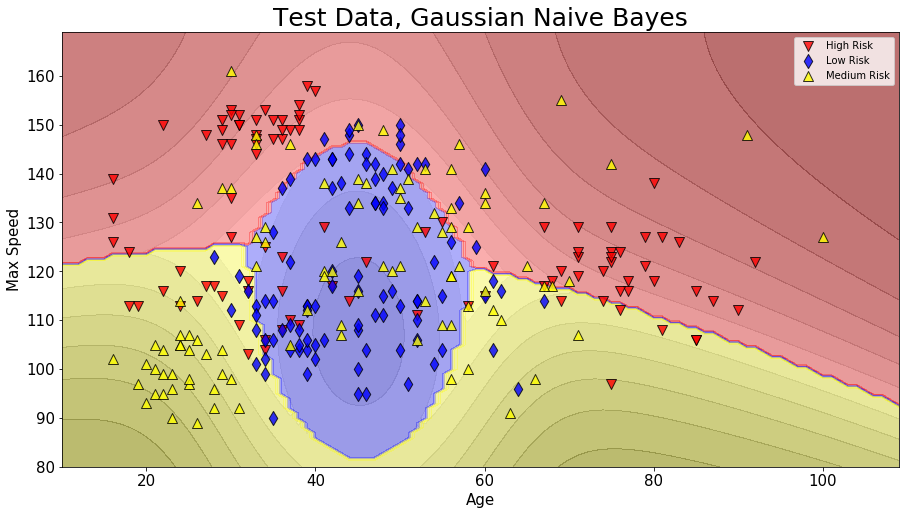

In [25]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Gaussian Naive Bayes")

In [26]:
clf.score(X_test_2_dim, y_test)

0.57

## Cross Validation

Test Data
* Test data for a real problem is sacred. 
* You should not use it to constantly improve your model, 
* but only as a final check that you did not fool yourself.
* You would want your test data to perform as closely to the training data as possible 

Cross Validation
* Let's you check on some data you have not used for training while not loosing more data for training
* Cross Validation splits the train data in different ways and performs a number of training runs (3 by default). 
* It will train using 2 sets and validate on the third. 
* You will expect your test data to perform closely to the cross validation scores

http://scikit-learn.org/stable/modules/cross_validation.html

In [0]:
clf = GaussianNB()

In [0]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [0]:
# StratifiedKFold?

In [0]:
# cross_val_score?

In [0]:
kfold = StratifiedKFold(n_splits=10)

In [32]:
%%time

# Naive Gaussian Bayes is really fast, we can use a lot of training runs
scores = cross_val_score(clf, X_train_2_dim, y_train, n_jobs=-1, cv=kfold)

CPU times: user 31.1 ms, sys: 27.9 ms, total: 59 ms
Wall time: 1.12 s


In [33]:
scores

array([0.6       , 0.6       , 0.53333333, 0.63333333, 0.54166667,
       0.55833333, 0.60833333, 0.65833333, 0.68333333, 0.64166667])

In [34]:
# mean score and the 95% confidence interval (2 standard deviations assuming normal distribution)
# https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.09)


## KNN: Look at the neighbors to make a prediction for a sample yet unknown

https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [0]:
from sklearn.neighbors import KNeighborsClassifier
# just looking at the single next neighbor and assume we are the same
clf = KNeighborsClassifier(1)

In [36]:
%%time

clf.fit(X_train_2_dim, y_train)

CPU times: user 2.63 ms, sys: 938 µs, total: 3.57 ms
Wall time: 12.5 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

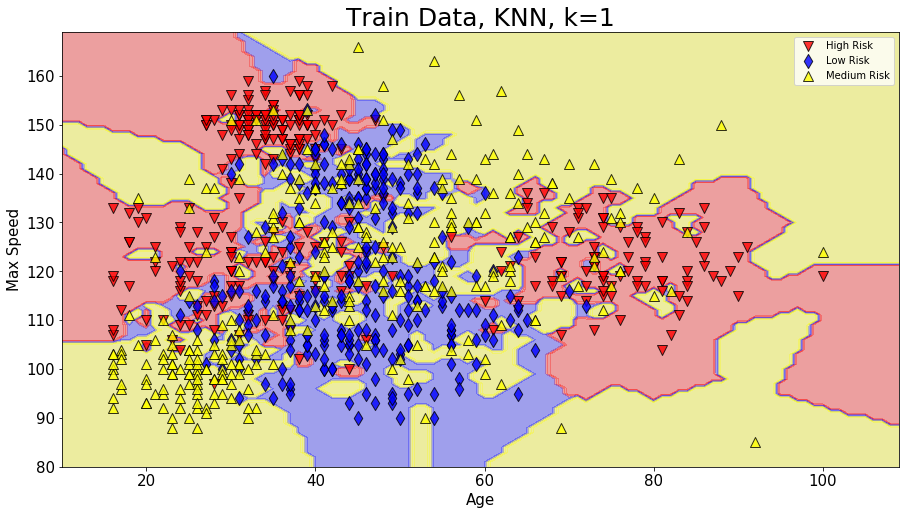

In [37]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, KNN, k=1", n_samples=900)

In [38]:
clf.score(X_train_2_dim, y_train)

0.9358333333333333

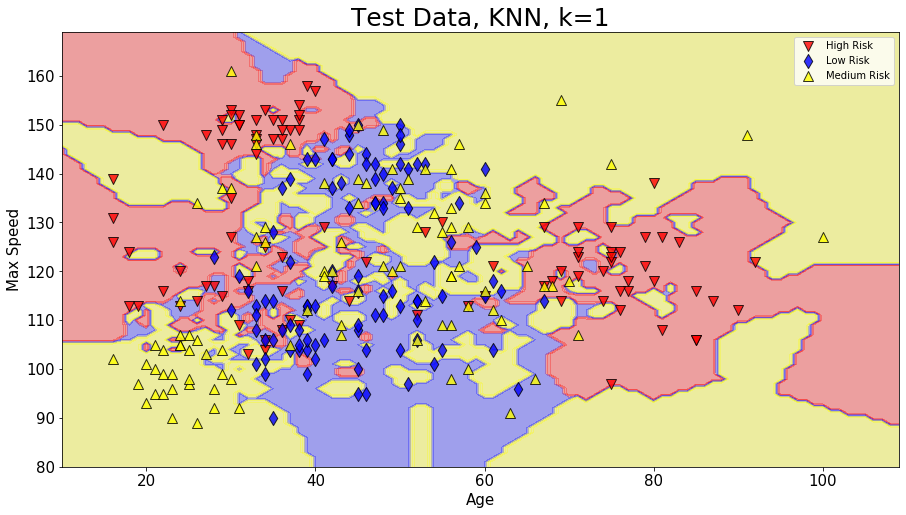

In [39]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN, k=1")

In [40]:
clf.score(X_test_2_dim, y_test)

0.6133333333333333

In [41]:
%%time

scores = cross_val_score(clf, X_train_2_dim, y_train, cv=100, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.62 (+/- 0.30)
CPU times: user 107 ms, sys: 3.87 ms, total: 111 ms
Wall time: 293 ms


# Exercise: Fight overfitting in KNN

* the number of neighbors (k) is the most important parameter
* Interactive experiment to see the effect of k: https://beta.observablehq.com/@djcordhose/how-to-build-a-teachable-machine-with-tensorflow-js#knndataset
* rule of thumb: smoother decision boundaries imply less overfitting
* execute the notebook up to this point
* change k based on your previous experiments
* what is the important value to check?

In [42]:
k = 1 # set your k here
clf = KNeighborsClassifier(k)
clf.fit(X_train_2_dim, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Searching for the best parameters

0.7166666666666667 11


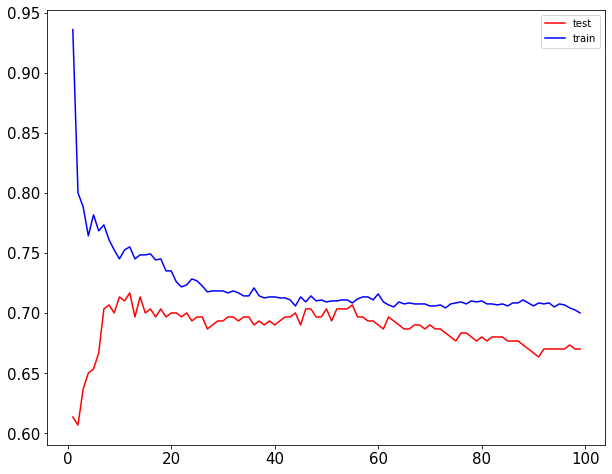

In [43]:
# let's manually implement a loop over one parameter first

# we cheat a little bit since we are using the test set here to tweak the
# parameters, so this is just to illustrate the point

from sklearn.neighbors import KNeighborsClassifier

s_test = []
s_train = []
ks = np.arange(1, 100, dtype=int)
for k in ks:
  clf = KNeighborsClassifier(k)
  clf.fit(X_train_2_dim, y_train)
  s_train.append(clf.score(X_train_2_dim, y_train))
  s_test.append(clf.score(X_test_2_dim, y_test))

s_test = np.array(s_test)
print(s_test.max(), s_test.argmax())

plt.figure(figsize=(10, 8))
plt.plot(ks, s_test, color='red', label='test')
plt.plot(ks, s_train, color='blue', label='train')
plt.legend()

In [44]:
k = 11
clf = KNeighborsClassifier(k)
clf.fit(X_train_2_dim, y_train)

print("Training score: {0:.2f}".format(clf.score(X_train_2_dim, y_train)))
print("Test score: {0:.2f}".format(clf.score(X_test_2_dim, y_test)))

Training score: 0.75
Test score: 0.71


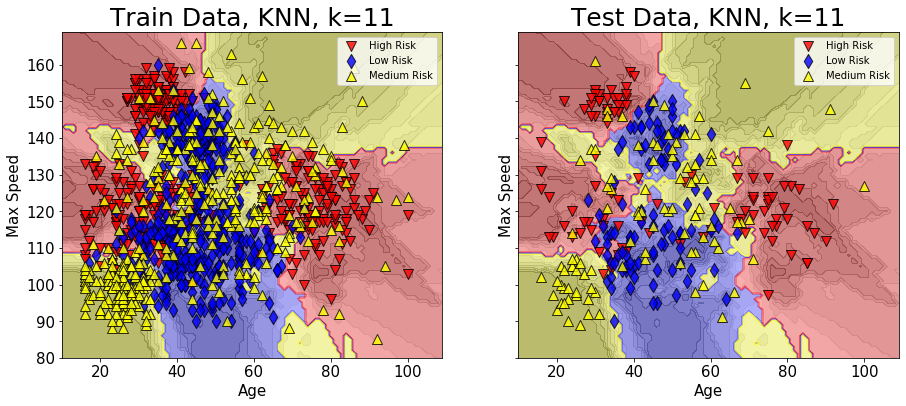

In [45]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,6))
la, ra = ax.flatten()

plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, KNN, k={0}".format(k),
                ax = la)

plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN, k={0}".format(k),
                ax = ra)

We can try what is the best number of numbers manually, but grid search does the same thing, only with less manual effort. This one tries the number of neighbors between 1 and 50

In [46]:
%%time 

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': list(range(1, 50)),
    'weights': ['uniform', 'distance'] # are points that are nearer more important?
    }
clf = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1)
clf.fit(X_train_2_dim, y_train)

CPU times: user 525 ms, sys: 20.7 ms, total: 546 ms
Wall time: 3.53 s


In [47]:
clf.best_params_

{'n_neighbors': 45, 'weights': 'uniform'}

In [48]:
%%time 

clf = KNeighborsClassifier(n_neighbors=14, weights='uniform')
clf.fit(X_train_2_dim, y_train)

CPU times: user 2.17 ms, sys: 16 µs, total: 2.19 ms
Wall time: 3.78 ms


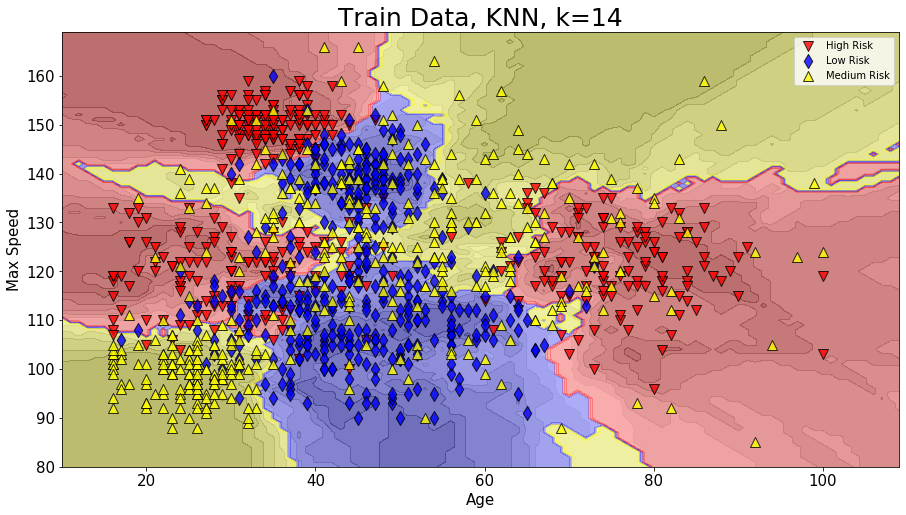

In [49]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, KNN, k=14")

In [50]:
clf.score(X_train_2_dim, y_train)

0.7483333333333333

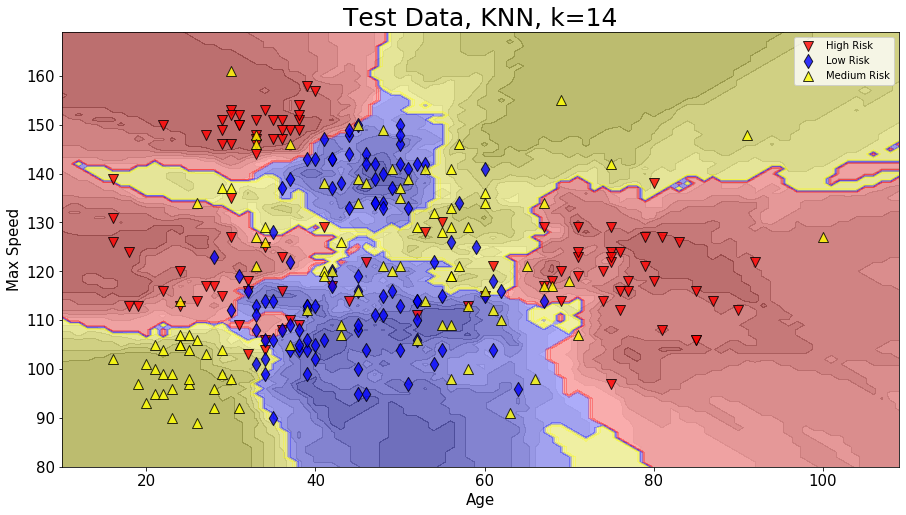

In [51]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN, k=14")

In [52]:
clf.score(X_test_2_dim, y_test)

0.7133333333333334

In [53]:
%%time

scores = cross_val_score(clf, X_train_2_dim, y_train, cv=100, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.71 (+/- 0.27)
CPU times: user 102 ms, sys: 6 ms, total: 108 ms
Wall time: 257 ms


# From here on choose your favorite topic

* spend an hour working on what you are most interested in
* Work at your one speed
* If you do not have a special interest look at ensemble methods with Random Forst (Sometimes called the Swiss Army Knive for machine learning)
* Ask coaches if you have questions or want to discuss



## Support Vector Machines (SVM)
* SVMs used to be the hot stuff before neural networks stole the show
* SVMs choose a small number of data points to decide where to draw the decision boundary, they are called the *support vectors*
* support vectors are typically close to the decision boundaries

### Linear SVM

In its base version SVMs can only use lines as decision boundaries. Let's see how well this works.

In [54]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', probability=True)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 3.09 s, sys: 4.02 ms, total: 3.1 s
Wall time: 3.12 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [55]:
clf.support_vectors_.shape

(1107, 2)

In [56]:
clf.score(X_train_2_dim, y_train)

0.4666666666666667

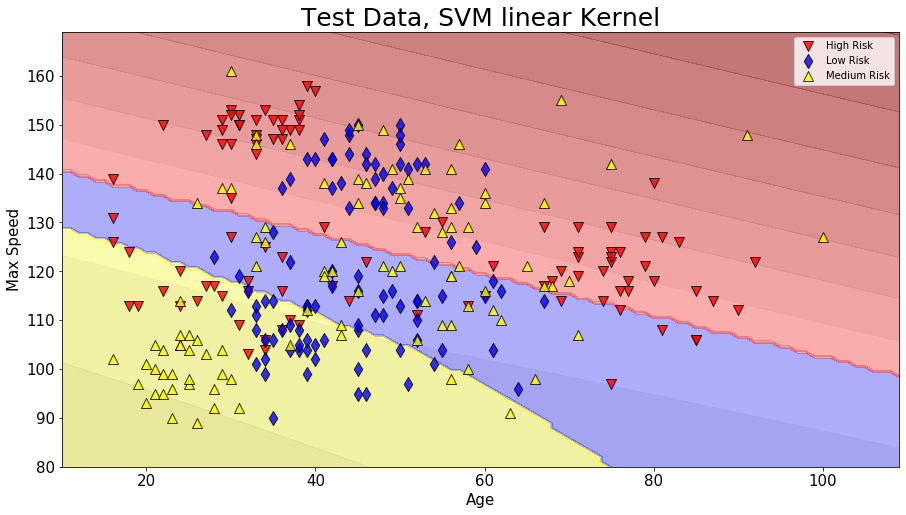

In [57]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM linear Kernel")

In [58]:
clf.score(X_test_2_dim, y_test)

0.43666666666666665

### SVM Kernels

_Kernel Trick allows to solve problems that are not linearly separable_

* As we can see using lines only, we can not even fit the training data, this is called *underfitting*.
* For most realisitic examples we need something better called the 'kernel trick'
* We transform the original problem space into a higher dimension that is separable by lines only
* Radial Base Functions 'rbf' can approximate any function and are trained to perform this transformation (https://en.wikipedia.org/wiki/Radial_basis_function_kernel)

<img src='https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/svm-kernel-trick.jpg?raw=1'>

Sebastian Thrun for Udacity: https://youtu.be/3Xw6FKYP7e4 


In [59]:
clf = SVC(kernel='rbf', probability=True)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 249 ms, sys: 2.04 ms, total: 251 ms
Wall time: 259 ms


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [60]:
clf.support_vectors_.shape

(934, 2)

In [61]:
clf.score(X_train_2_dim, y_train)

0.6708333333333333

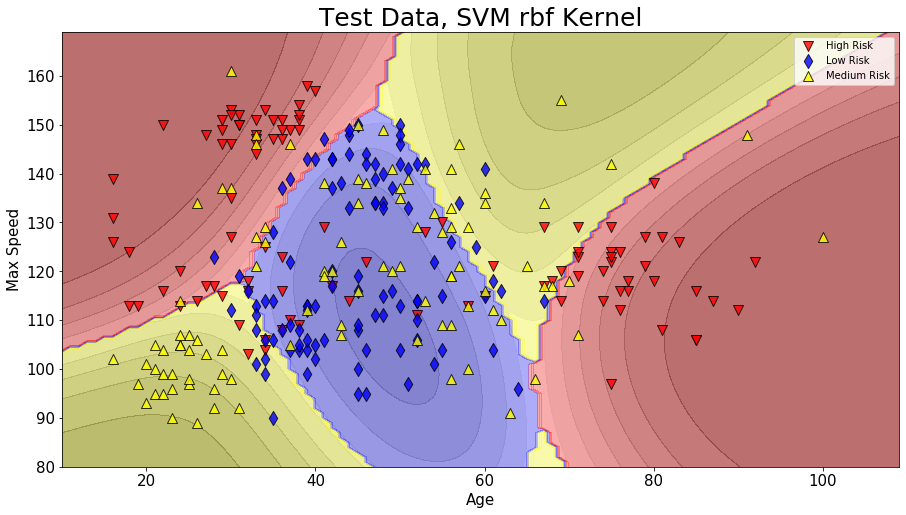

In [62]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM rbf Kernel")

In [63]:
clf.score(X_test_2_dim, y_test)

0.66

Again we strongly overfit and need to regularize our model. The two important parameters are
* Gamma
  * reach of a single training sample - low values: far, high values: close
    * https://www.youtube.com/watch?v=m2a2K4lprQw
  * the lower the more points remote from the support vectors influence where the decision boundaries go  
* C (Cost)
  * decides how expensive it is to misclassify one of our support vectors, the smaller the more tolerant to misclassified samples
  * tradeof between smooth decision boundaries and classifying samples correctly
    * https://www.youtube.com/watch?v=joTa_FeMZ2s
    * high cost means rough, complex decision boundaries
    * lower cost means more regularization

Interactively experiment with C and Gamma: https://dash-gallery.plotly.host/dash-svm

http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [64]:
param_grid = {
    'C': list(np.append(np.arange(0.1, 1.0, 0.1), np.arange(2, 10, 1))),
    'gamma': list(np.append(np.arange(0.001, 0.1, 0.0005), np.arange(.02, 1.0, 0.1))),
}
clf = GridSearchCV(SVC(), param_grid, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

CPU times: user 31.3 s, sys: 915 ms, total: 32.3 s
Wall time: 12min 57s


{'C': 8.0, 'gamma': 0.004}

In [65]:
clf = SVC(kernel='rbf', probability=True, C=0.3, gamma=0.023)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 245 ms, sys: 2.08 ms, total: 247 ms
Wall time: 251 ms


SVC(C=0.3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.023, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [66]:
clf.score(X_train_2_dim, y_train)

0.7475

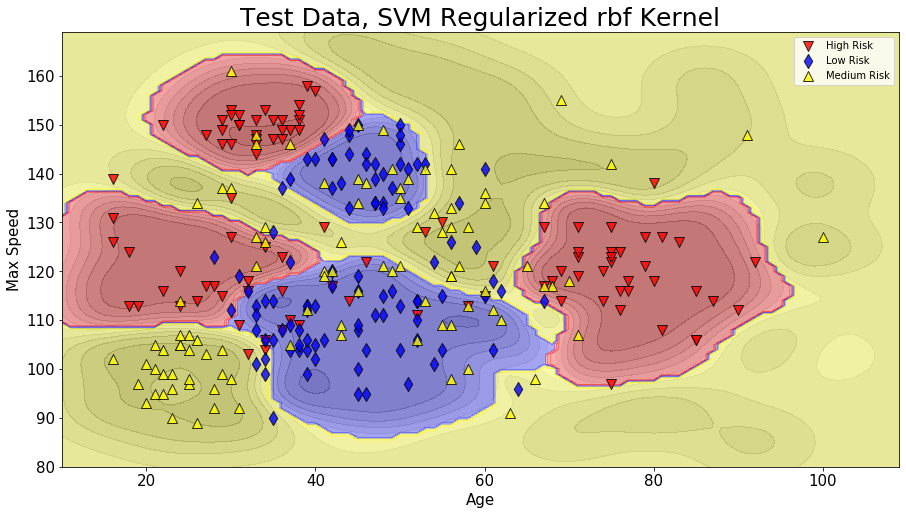

In [67]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM Regularized rbf Kernel")

In [68]:
clf.score(X_test_2_dim, y_test)

0.72

# Exercise: Improve Cost and Gamma
* use https://dash-gallery.plotly.host/dash-svm to get a better intuition for C and Gamma
* Change C and Gamma based on your intuition
* Can you do better than the results coming from the grid search?
* If not: Why not?

## Descision Trees

* Split our data set on a certain variable
* Similar to what we have done in the manual classifier, but here the rules are actually learned

In [69]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 2.32 ms, sys: 16 µs, total: 2.33 ms
Wall time: 2.42 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### How is the Decision Tree being Constructed?

We are using the CART algorithm:
* top-down split the set of examples into two new sets
* choose a variable and a value at each step that best splits our customer example
* terminal node when no further gain possible or regularization kicks in

<img src="https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/dt/cart.png">

http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart

### What is the best split?

* choose a feature to split on (either random or best)
* assign a category to each node containing a certain set of samples
* use a metric (Gini or Entropy) to decide how good a node would be based on that category
* sum up weighted metric for both child nodes
* optimize the split for that summed metric

https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/

In [70]:
# we perform at most 18 splits of our data until we make a decision where the data point belongs

clf.tree_.max_depth

18

### Complete Decision Tree

<img src="https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/dt-all.png?raw=1">

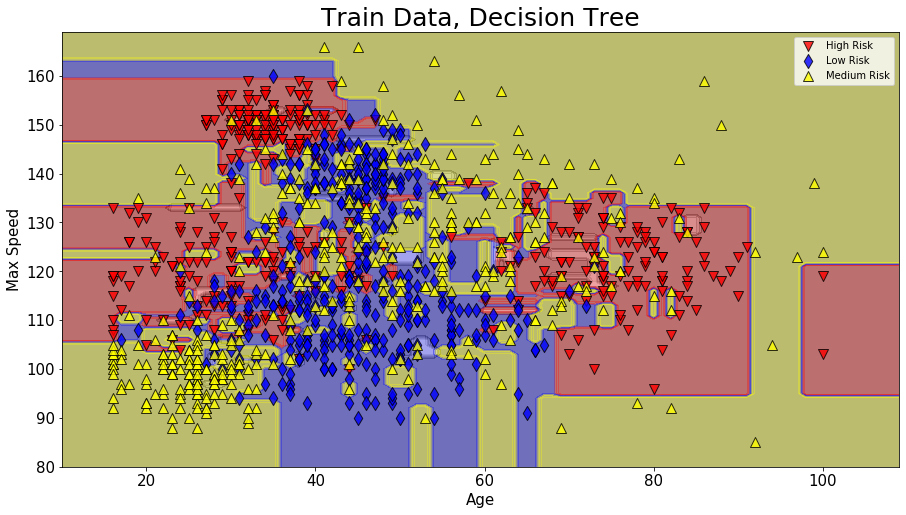

In [71]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Decision Tree")

In [72]:
clf.score(X_train_2_dim, y_train)

0.9425

In [73]:
%%time
scores = cross_val_score(clf, X_train_2_dim, y_train, cv=100, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.29)
CPU times: user 122 ms, sys: 2.3 ms, total: 124 ms
Wall time: 367 ms


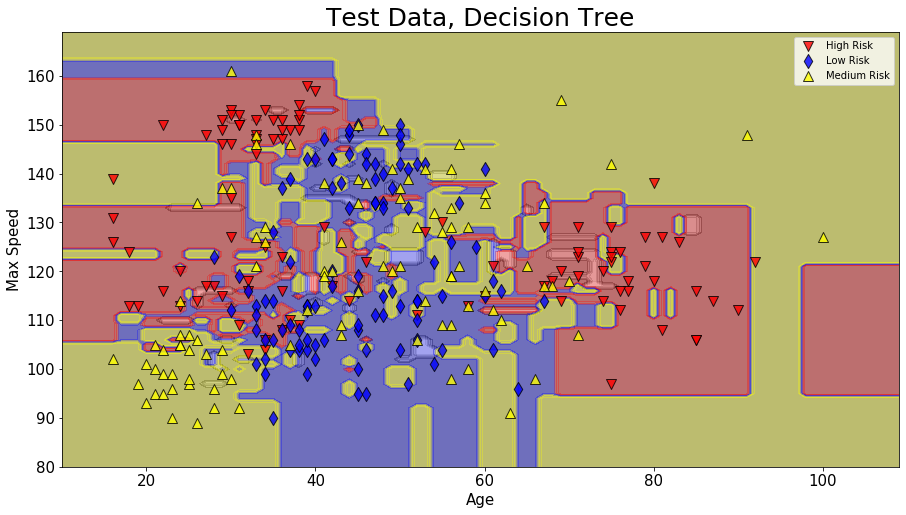

In [74]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree")

In [75]:
clf.score(X_test_2_dim, y_test)

0.6033333333333334

We overfit heavily and need to change the relevant parameters of our tree
* its maximum number of splits (depth) - if there is no limit, we can make as many splits as it takes to perfectly match all train data (overfitting)
* how many samples we need at least for a leaf - if it is just one, we could perfectly fit all training data (overfitting)
* how many samples do we need to make another split - not as crucial as the other two, but can still limit overfitting

In [76]:
param_grid = {
    'max_depth': list(range(2, 25)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

CPU times: user 6.71 s, sys: 61.9 ms, total: 6.77 s
Wall time: 16.9 s


{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [77]:
clf = DecisionTreeClassifier(max_depth=6,
                              min_samples_leaf=2,
                              min_samples_split=2)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 1.54 ms, sys: 978 µs, total: 2.51 ms
Wall time: 2.11 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [78]:
clf.tree_.max_depth

6

In [79]:
clf.score(X_train_2_dim, y_train)

0.7325

### Reduced Decision Tree

<img src="https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/dt-lvl3.png?raw=1">

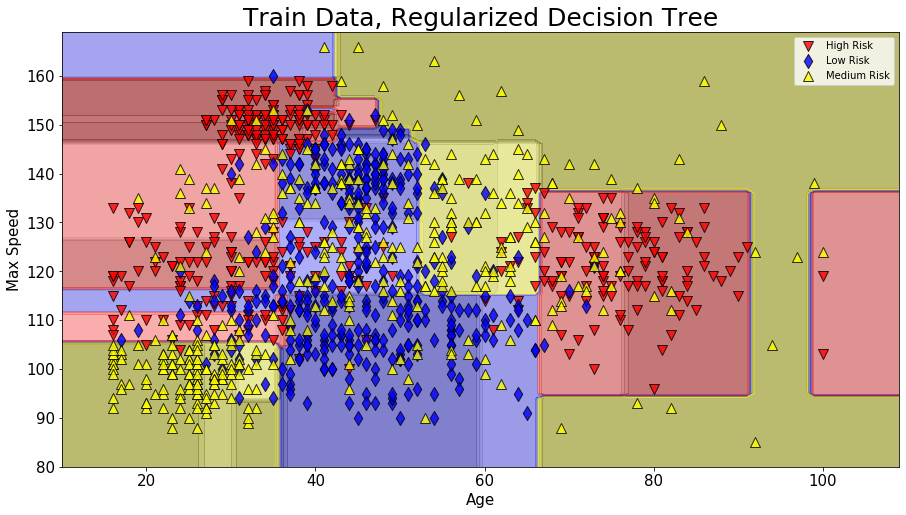

In [80]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Decision Tree")

In [81]:
clf.score(X_test_2_dim, y_test)

0.6533333333333333

In [82]:
%%time

scores = cross_val_score(clf, X_train_2_dim, y_train, cv=100, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.69 (+/- 0.27)
CPU times: user 114 ms, sys: 4.31 ms, total: 118 ms
Wall time: 292 ms


## Ensemble Methods on Decision Trees

* Decision Trees in particular have nice properties, but tend to overfit
* We fight overfitting in decision trees with some success
* However, inherent to their nature, decision trees tend to overfit
* Combining more than one classifier is called an "emsemble method"
* Results from individual will be either averaged, majorty, or boosted by others 

### Bagging
* train a number of estimators using only a subset of your data (https://youtu.be/Cn7StaXU_8o)


## Random Forest
* Random Forest is an ensemble technique that trains a number of simple decision trees and uses a majority vote over all of them for prediction
* like Bagging but with additional random selection of features
* Typically uses average of median for regression
* While each decision tree still overfits using many of them softens this problems
* You still need to regularize the underlying decision trees
* sklearn has a default of 10 decision trees for random forest

_Random Forest sometimes is called the swiss army knife of machine learning_

In [83]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 344 ms, sys: 38.6 ms, total: 383 ms
Wall time: 358 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [84]:
clf.score(X_train_2_dim, y_train)

0.9425

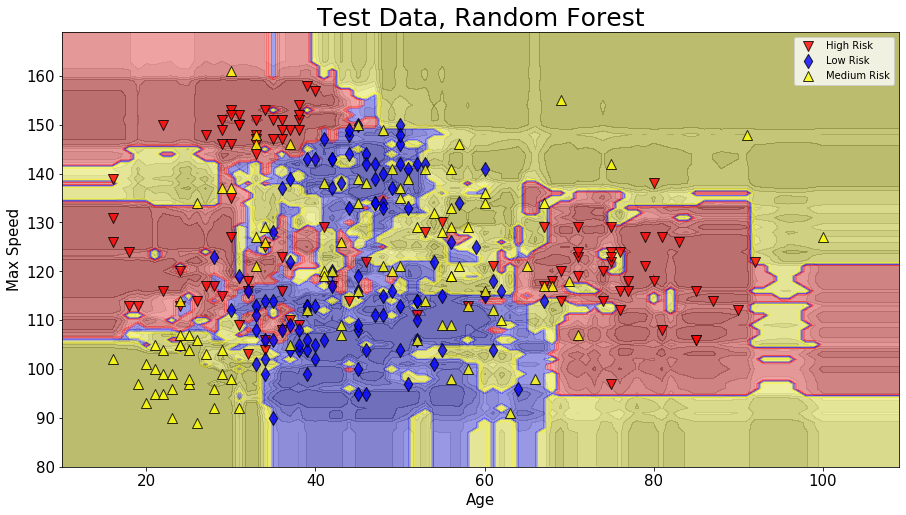

In [85]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Random Forest")

In [86]:
clf.score(X_test_2_dim, y_test)

0.65

## Random Search

Unfortunately, training random forest classifiers is more expensive than decision trees by the number of estimators it uses (10 in our case). This often  makes using a deterministic grid search over all parameters prohibitively expensive even when you can parallelize over many CPUs. We instead use a randomized search, that tries a number of different combinations and we hope to find the best here.

http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search


In [0]:
# brute force grid search is far too expensive

param_grid = {
    'n_estimators': list(range(3,20)),
    'max_depth': list(range(2, 25)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}
clf = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1)
# %time clf.fit(X_train_2_dim, y_train)
# clf.best_params_

In [88]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(3,20),
    "max_depth": randint(2, 25),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11)
}

clf = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=1000, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

CPU times: user 7.36 s, sys: 165 ms, total: 7.53 s
Wall time: 1min 38s


{'max_depth': 18,
 'min_samples_leaf': 5,
 'min_samples_split': 7,
 'n_estimators': 15}

In [89]:
# parameters found might vary a bit with each run, because it is a random search
clf = RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=5, n_estimators=14, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 49.5 ms, sys: 4.43 ms, total: 53.9 ms
Wall time: 116 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=14, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [90]:
clf.score(X_train_2_dim, y_train)

0.7683333333333333

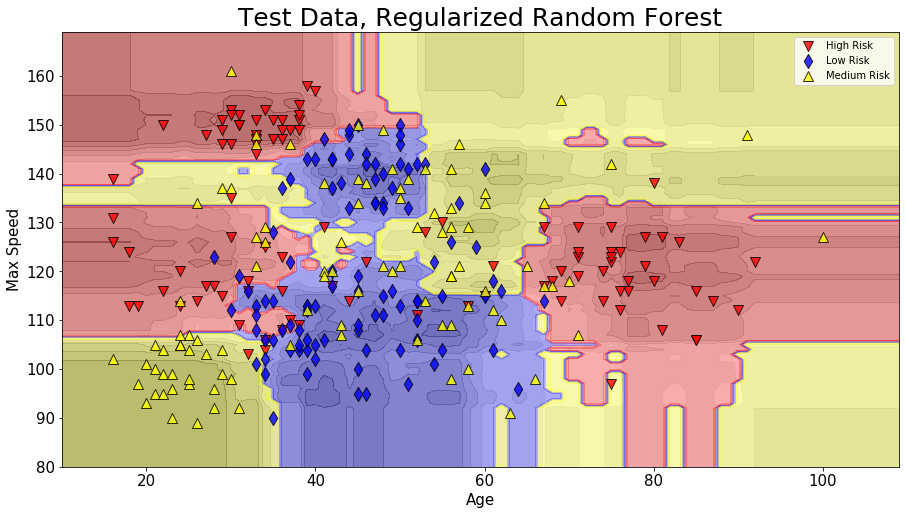

In [91]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Random Forest")

In [92]:
clf.score(X_test_2_dim, y_test)

0.6866666666666666

In [93]:
%%time

scores = cross_val_score(clf, X_train_2_dim, y_train, cv=100, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.71 (+/- 0.24)
CPU times: user 289 ms, sys: 8.24 ms, total: 297 ms
Wall time: 10.7 s


# Exercise: Try to optimize on the parameters
* we only have a good guess about the optimal parameters here
* re-run the ramdomized search and try to get better results
* you can also try the grid seach with a limited search range 

## AdaBoost

* begins by fitting a classifier on the original dataset
* by default in Scikit-learn this will be a decision tree, but you are free to choose whatever you want
* draws random samples from the training data 
* then fits additional copies of the classifier on the same dataset
* incorrectly classified samples are more likely to be used in subsequent classifiers 
* as a consequence subsequent classifiers focus more on difficult cases
* classifiers are combined like in other ensemble methods

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

<br>
<Img src='https://github.com/djcordhose/ml-workshop/blob/master/notebooks/classic/img/boosting.jpg?raw=1' height=300>
  
Taken from this clear and concise explanation video: https://youtu.be/GM3CDQfQ4sw

In [94]:
from sklearn.ensemble import AdaBoostClassifier
# due to its nature can not run in parallel
clf = AdaBoostClassifier()
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 105 ms, sys: 2.07 ms, total: 107 ms
Wall time: 113 ms


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [95]:
clf.score(X_train_2_dim, y_train)

0.6941666666666667

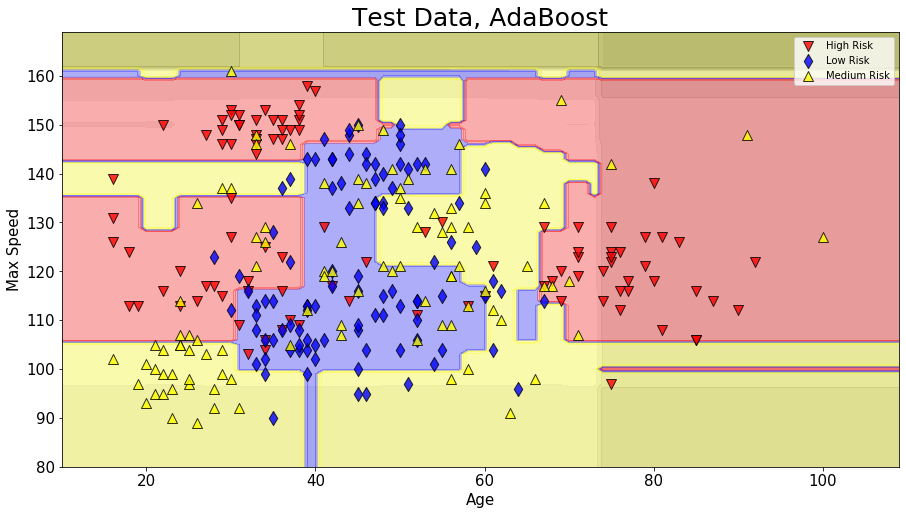

In [96]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, AdaBoost")

In [97]:
clf.score(X_test_2_dim, y_test)

0.6466666666666666

### AdaBoost sucks, unfortunately

* very few parameters to tweak or find via GridSearch
* not very good results
* state of the art libraries such as XGBoost and LightGBM kick its ass

#### Fortunately, there are options
* one pretty stable: GradientBoostingClassifier
* the other pretty fancy: HistGradientBoostingClassifier
  * uses histograms of binned features to evaluate the tree node spit candidates
  * can efficiently leverage multi-core CPUs and is competitive with XGBoost and LightGBM

https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting


In [98]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [0]:
from sklearn.ensemble import GradientBoostingClassifier 

In [0]:
# GradientBoostingClassifier?

In [101]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [102]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
HistGradientBoostingClassifier().get_params()

{'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'auto',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'n_iter_no_change': None,
 'random_state': None,
 'scoring': None,
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [103]:
clf = HistGradientBoostingClassifier(max_iter=50)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 1.21 s, sys: 49.7 ms, total: 1.26 s
Wall time: 663 ms


HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.1,
                               loss='auto', max_bins=255, max_depth=None,
                               max_iter=50, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=None, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

In [104]:
clf.score(X_train_2_dim, y_train)

0.8316666666666667

In [105]:
clf.score(X_test_2_dim, y_test)

0.6566666666666666

In [106]:
%%time

from scipy.stats import expon, uniform

param_dist = {
    'learning_rate': expon(loc=0.001, scale=0.5),
    'l2_regularization': uniform(loc=0, scale=0.5),
    'max_depth': randint(2, 20),
    'max_leaf_nodes': randint(5, 30),
    'min_samples_leaf': randint(5, 30)
}

clf = RandomizedSearchCV(HistGradientBoostingClassifier(), param_dist, n_iter=100, n_jobs=-1)
clf.fit(X_train_2_dim, y_train)
print(clf.best_params_)

{'l2_regularization': 0.4365263022356825, 'learning_rate': 0.02524779029840671, 'max_depth': 10, 'max_leaf_nodes': 8, 'min_samples_leaf': 7}
CPU times: user 2.46 s, sys: 86.8 ms, total: 2.54 s
Wall time: 3min 2s


In [107]:
df_results = pd.DataFrame(clf.cv_results_)
columns = (['mean_test_score', 'std_test_score'] +
           [col for col in df_results.columns if 'param_' in col])
df_results.sort_values(by='mean_test_score', ascending=False)[
    columns
].head()

mean_test_score  std_test_score  ... param_max_leaf_nodes param_min_samples_leaf
36         0.704167        0.048805  ...                    8                      7
21         0.701667        0.049483  ...                    7                      8
28         0.696667        0.051465  ...                   25                     29
51         0.695000        0.039211  ...                    8                     20
2          0.695000        0.045901  ...                   22                     21

[5 rows x 7 columns]

In [108]:
clf = HistGradientBoostingClassifier(l2_regularization=0.006909764841591504, learning_rate = 0.02749723325600879, max_depth= 12, max_leaf_nodes= 9, min_samples_leaf= 15)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 778 ms, sys: 34.1 ms, total: 812 ms
Wall time: 415 ms


HistGradientBoostingClassifier(l2_regularization=0.006909764841591504,
                               learning_rate=0.02749723325600879, loss='auto',
                               max_bins=255, max_depth=12, max_iter=100,
                               max_leaf_nodes=9, min_samples_leaf=15,
                               n_iter_no_change=None, random_state=None,
                               scoring=None, tol=1e-07, validation_fraction=0.1,
                               verbose=0, warm_start=False)

In [109]:
clf.score(X_train_2_dim, y_train)

0.7583333333333333

In [110]:
clf.score(X_test_2_dim, y_test)

0.71

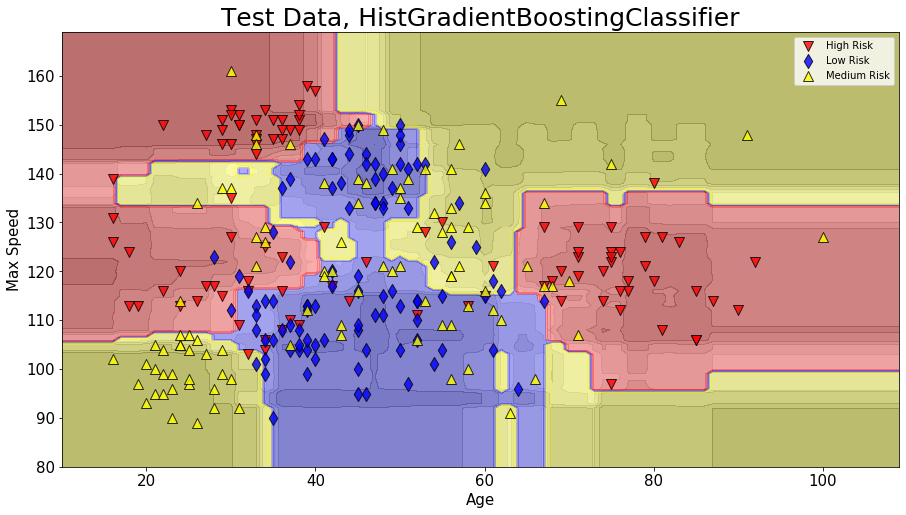

In [111]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, HistGradientBoostingClassifier");

# Advanced Bonus: Neural Networks using TensorFlow 2

In [112]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [113]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [114]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [115]:
# this should return True even on Colab
assert tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
# we have the gpu version of TensorFlow running
assert tf.test.is_built_with_cuda()

In [117]:
# What kind of GPU are we running on
!nvidia-smi

Thu Jan  9 13:18:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    57W / 149W |     69MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [118]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation

num_features = 2
num_categories = 3

dropout = 0.6
model = tf.keras.Sequential()

model.add(Input(name='input', shape=(num_features,)))

model.add(Dense(name='hidden1', units=150))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='hidden2', units=100))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 150)               450       
_________________________________________________________________
activation (Activation)      (None, 150)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150)               600       
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               15100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               4

In [119]:
%%time 

BATCH_SIZE=1000
EPOCHS = 2000

history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

CPU times: user 31.5 s, sys: 3.06 s, total: 34.6 s
Wall time: 30.5 s


In [120]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.7079218228658041, 0.7058333)

In [121]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.7287899255752563, 0.68666667)

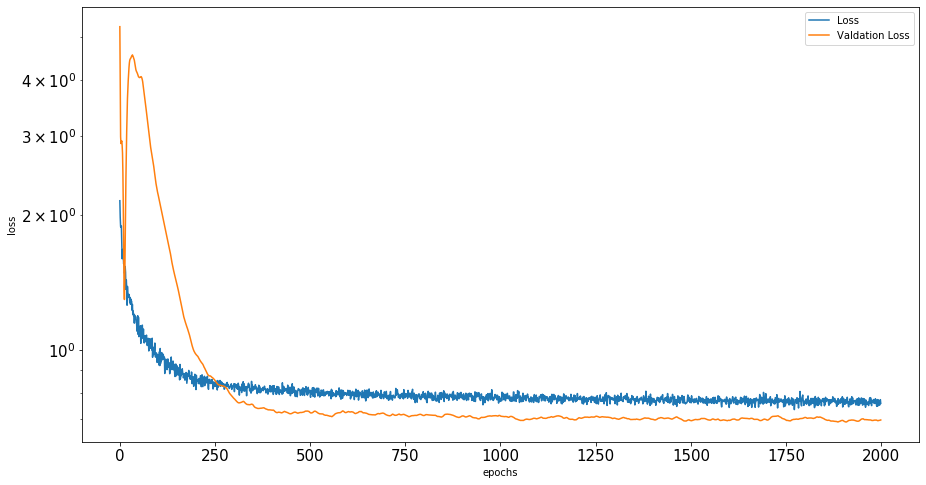

In [122]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"])

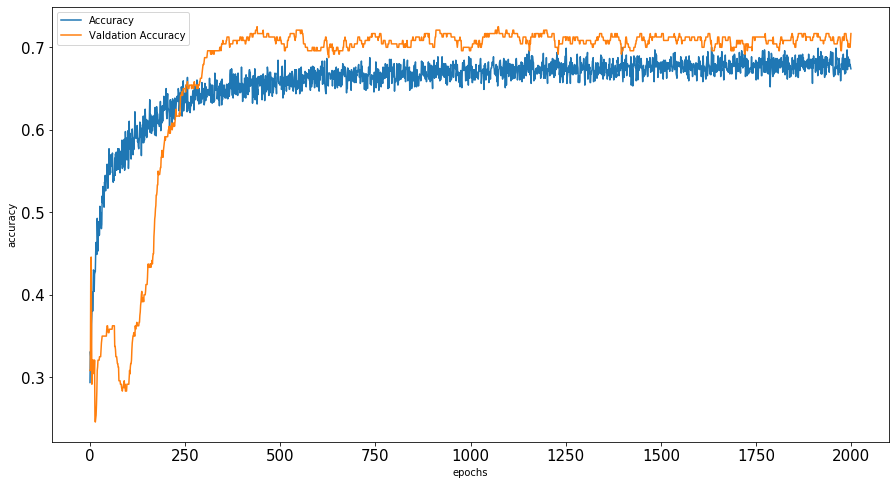

In [123]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"])

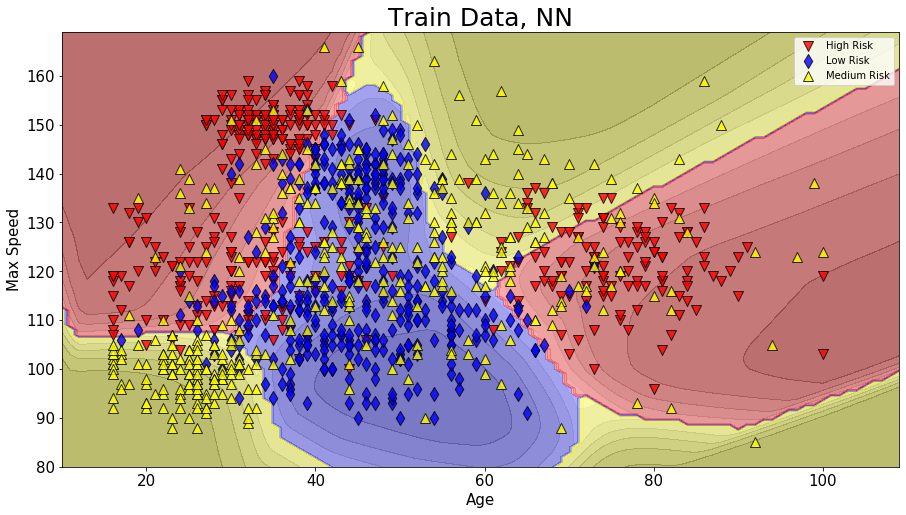

In [124]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, NN")

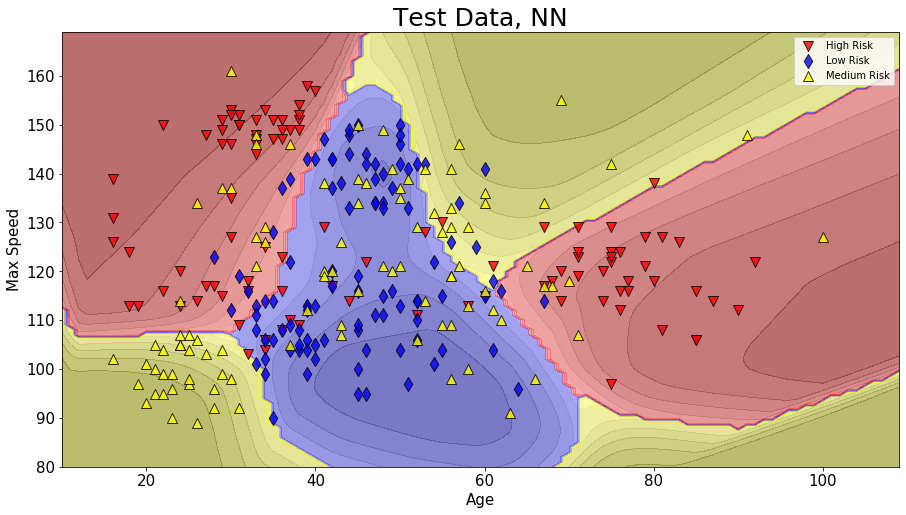

In [125]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN")

# Exercise: Neural Network
* scores are a bit lower than random forest: looking at the plot of the decision boundaries could you still find a reason for favoring neural networks over random forests?
* can you improve the results? try training for more epochs or making the layers larger or adding more layers
* can you imagine what the main challenges with neural networks might be?

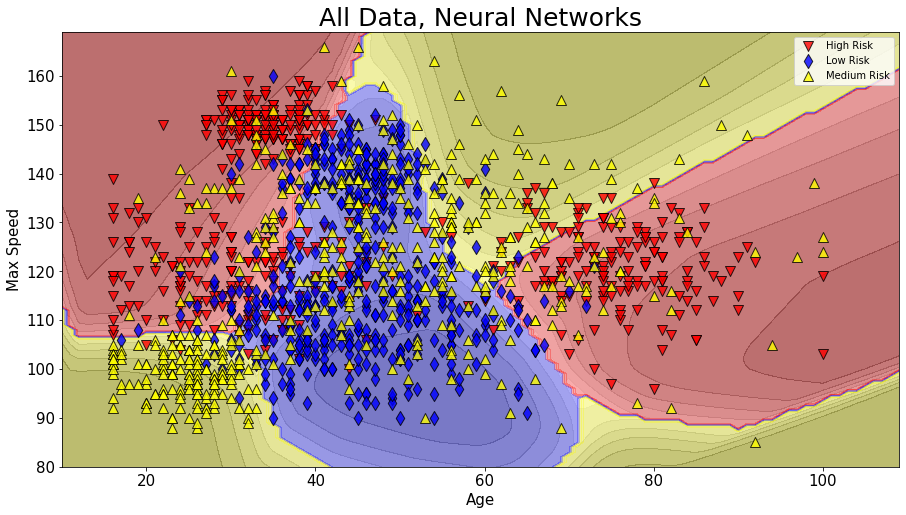

In [126]:
plotPrediction(model, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data, Neural Networks")